In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [3]:
comp_pre = jx.Compartment()
branch_pre = jx.Branch(comp_pre, ncomp=1)
parents_pre = np.asarray([-1])           
cell_pre = jx.Cell(branch_pre, parents=parents_pre)

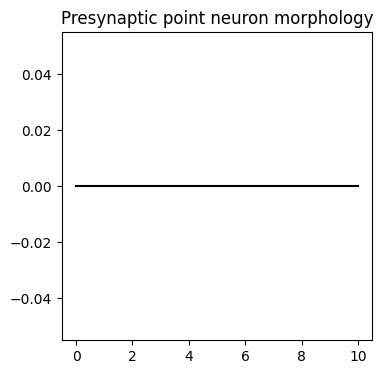

In [4]:
cell_pre.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell_pre.vis(ax=ax)
ax.set_title("Presynaptic point neuron morphology");

In [5]:
n_post_comp = 15
comp_post = jx.Compartment()
branch_post = jx.Branch(comp_post, ncomp=n_post_comp)   
parents_post = np.asarray([-1])          
cell_post = jx.Cell(branch_post, parents=parents_post)

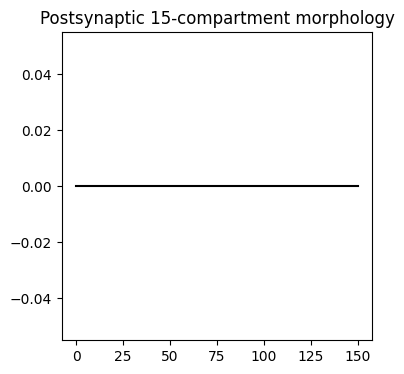

In [6]:
cell_post.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell_post.vis(ax=ax)
ax.set_title("Postsynaptic 15-compartment morphology");

In [7]:
num_pre = 8                    
pre_cells = [cell_pre for _ in range(num_pre)]
cells = pre_cells + [cell_post]
net = jx.Network(cells)


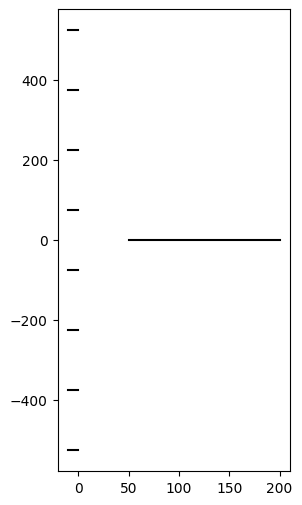

In [8]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[num_pre, 1], within_layer_offset=150, between_layer_offset=200)
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

In [9]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

In [10]:
syn = IonotropicSynapse()
post_idx = num_pre

post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)

for pre_idx, comp_idx in zip(range(num_pre), post_comp_indices):
    pre_comp  = net.cell(pre_idx).branch(0).comp(0)           # presyn soma
    post_comp = net.cell(post_idx).branch(0).comp(int(comp_idx))
    connect(pre_comp, post_comp, syn)

print("Ionotropic edges:", net.IonotropicSynapse.edges.shape)

Ionotropic edges: (8, 16)


ABOVE SHOULD YIELD (8, 16) NEED TO FIX BC RE RUNNING ADDS UNOBSERVABLE EDGES

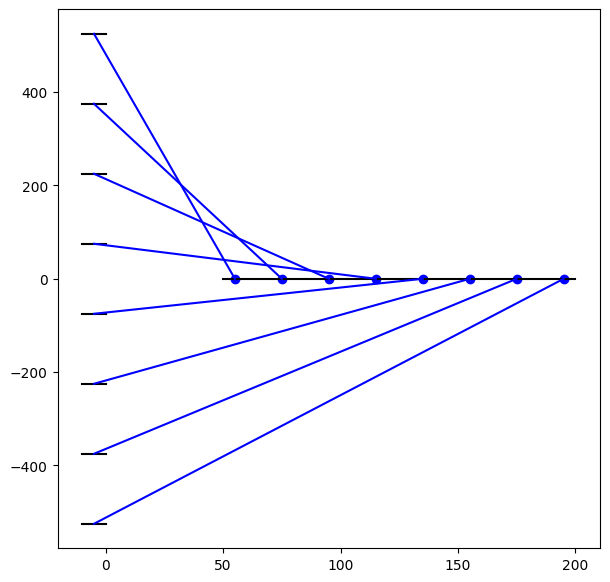

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = net.vis(ax=ax, detail="full")

In [12]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,8,IonotropicSynapse,0,0.5,0.033333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,1,10,IonotropicSynapse,0,0.5,0.166667,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,2,12,IonotropicSynapse,0,0.5,0.300000,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,3,14,IonotropicSynapse,0,0.5,0.433333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,4,16,IonotropicSynapse,0,0.5,0.566667,0.0001,0.0,0.025,-35.0,10.0,0.2,0
5,5,5,5,18,IonotropicSynapse,0,0.5,0.700000,0.0001,0.0,0.025,-35.0,10.0,0.2,0
6,6,6,6,20,IonotropicSynapse,0,0.5,0.833333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
7,7,7,7,22,IonotropicSynapse,0,0.5,0.966667,0.0001,0.0,0.025,-35.0,10.0,0.2,0


In [14]:
# net.set("IonotropicSynapse_gS", 0.0005)
# net.edges

In [13]:
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

dt = 0.025  # ms
t_max = 50.0  # ms

In [15]:
time_vec = np.arange(0.0, t_max + dt, dt)

In [14]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(num_pre):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


In [ ]:
net.delete_recordings()
# net.cell(post_idx).branch(0).loc(0.0).record()
post_branch = net.cell(post_idx).branch(0)
locs = np.linspace(0.0, 1.0, n_post_comp) 
post_branch.loc(locs).record()



Added 15 recordings. See `.recordings` for details.


In [17]:
traces = jx.integrate(net, delta_t=dt)

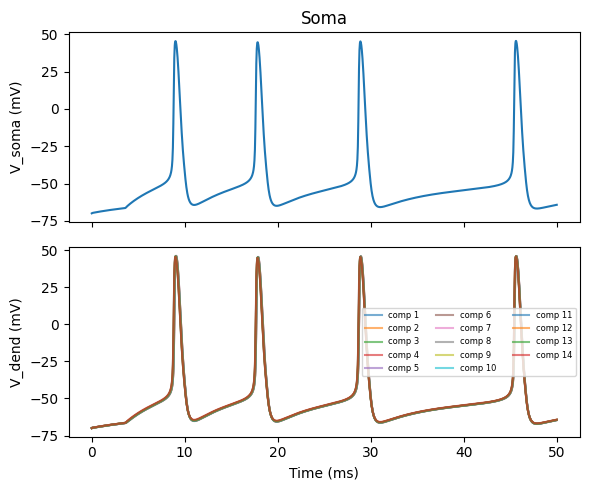

In [18]:
soma_trace = traces[0]
dend_traces  = traces[1:, :]  

T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

# soma
axes[0].plot(time_vec, soma_trace)
axes[0].set_ylabel("V_soma (mV)")
axes[0].set_title("Soma")

# dendrites
for i in range(dend_traces.shape[0]):
    axes[1].plot(time_vec, dend_traces[i], alpha=0.6, label=f"comp {i+1}")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("V_dend (mV)")
axes[1].legend(fontsize=6, ncol=3)

plt.tight_layout()
plt.show()

In [19]:
branch = net.cell(post_idx).branch(0)
for l in locs:
    view = branch.loc(l)
    print(l, np.unique(view.nodes["local_comp_index"]))


0.0 [0]
0.07142857142857142 [0]
0.14285714285714285 [0]
0.21428571428571427 [0]
0.2857142857142857 [0]
0.3571428571428571 [0]
0.42857142857142855 [0]
0.5 [0]
0.5714285714285714 [0]
0.6428571428571428 [0]
0.7142857142857142 [0]
0.7857142857142857 [0]
0.8571428571428571 [0]
0.9285714285714285 [0]
1.0 [0]


In [20]:
branch = net.cell(post_idx).branch(0)

for l in locs:
    view = branch.loc(l)
    inds  = np.unique(view.nodes["global_comp_index"])
    print(l, inds)


0.0 [8]
0.07142857142857142 [9]
0.14285714285714285 [10]
0.21428571428571427 [11]
0.2857142857142857 [12]
0.3571428571428571 [13]
0.42857142857142855 [14]
0.5 [15]
0.5714285714285714 [16]
0.6428571428571428 [17]
0.7142857142857142 [18]
0.7857142857142857 [19]
0.8571428571428571 [20]
0.9285714285714285 [21]
1.0 [22]


In [21]:
rec_view = branch.loc(locs)
print(rec_view.nodes[["global_comp_index", "local_comp_index"]])


    global_comp_index  local_comp_index
8                   8                 0
9                   9                 1
10                 10                 2
11                 11                 3
12                 12                 4
13                 13                 5
14                 14                 6
15                 15                 7
16                 16                 8
17                 17                 9
18                 18                10
19                 19                11
20                 20                12
21                 21                13
22                 22                14


In [22]:
for idx, comp_trace in enumerate(dend_traces):
    print("comp", idx + 1, "shape:", comp_trace.shape)
    max_diff = jnp.max(jnp.abs(soma_trace - comp_trace))
    print(f"max diff soma vs comp {idx+1}: {float(max_diff):.6g}")

comp 1 shape: (2002,)
max diff soma vs comp 1: 4.61865
comp 2 shape: (2002,)
max diff soma vs comp 2: 11.0547
comp 3 shape: (2002,)
max diff soma vs comp 3: 19.549
comp 4 shape: (2002,)
max diff soma vs comp 4: 26.8585
comp 5 shape: (2002,)
max diff soma vs comp 5: 32.8485
comp 6 shape: (2002,)
max diff soma vs comp 6: 36.7572
comp 7 shape: (2002,)
max diff soma vs comp 7: 38.5606
comp 8 shape: (2002,)
max diff soma vs comp 8: 36.7572
comp 9 shape: (2002,)
max diff soma vs comp 9: 32.8485
comp 10 shape: (2002,)
max diff soma vs comp 10: 26.8585
comp 11 shape: (2002,)
max diff soma vs comp 11: 19.549
comp 12 shape: (2002,)
max diff soma vs comp 12: 11.0547
comp 13 shape: (2002,)
max diff soma vs comp 13: 4.61865
comp 14 shape: (2002,)
max diff soma vs comp 14: 4.24372e-11


In [ ]:
for k in range(15):
    j = 14 - k
    diff = jnp.max(jnp.abs(traces[k] - traces[j]))
    print(f"pair ({k}, {j}) max diff: {float(diff):.3g}")


pair (0, 14) max diff: 4.24e-11
pair (1, 13) max diff: 7.03e-11
pair (2, 12) max diff: 3.41e-11
pair (3, 11) max diff: 5.05e-11
pair (4, 10) max diff: 3.39e-11
pair (5, 9) max diff: 3.58e-11
pair (6, 8) max diff: 4.22e-11
pair (7, 7) max diff: 0
pair (8, 6) max diff: 4.22e-11
pair (9, 5) max diff: 3.58e-11
pair (10, 4) max diff: 3.39e-11
pair (11, 3) max diff: 5.05e-11
pair (12, 2) max diff: 3.41e-11
pair (13, 1) max diff: 7.03e-11
pair (14, 0) max diff: 4.24e-11


all traces look the same in plotting, but are different (see numerical diffs) though we do have some left-right symmetry going on

TRAINING

In [23]:
from jax import jit, vmap, value_and_grad
import jaxley.optimize.transforms as jt

In [24]:
net.delete_trainables()
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

params_true = net.get_parameters()


Number of newly added trainable parameters: 8. Total number of trainable parameters: 8


In [26]:
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)

In [ ]:
base_amp = i_amp # nA when bit = 1

def simulate(params, pattern, soma_only=True):
    """
    pattern: (n_pre,) binary 0/1
    returns: soma trace (timepoints,)
    """
    # pattern scales the step amplitudes
    amps = base_amp * pattern  # (n_pre,)

    # Jaxley helper: gives one step-current trace per input dimension
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps,
        delta_t=dt, t_max=t_max
    )  # shape (n_pre, T)

    net.delete_stimuli()

    # build data_stimuli for this pattern
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    traces = jx.integrate(
        net,
        params=params,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )  # shape (num_recordings, T)

    if soma_only:
        return traces[0]  # (T,)
    else:
        return traces  # (num_recordings, T)

def simulate_soma(params, pattern):
    return simulate(params, pattern, soma_only=True)

def simulate_all(params, pattern):
    return simulate(params, pattern, soma_only=False)

# Batched version over many patterns for soma only
batched_simulate = vmap(simulate_soma, in_axes=(None, 0))  # params shared, patterns batched


In [28]:
import jax

In [29]:
key = jax.random.PRNGKey(0)
n_samples = 200   # total dataset size

patterns = jax.random.bernoulli(key, p=0.5, shape=(n_samples, num_pre))
patterns = patterns.astype(np.float64)

params_true = transform.forward(opt_params_true)

targets = batched_simulate(params_true, patterns)

In [30]:
split = int(0.8 * n_samples)
patterns_train = patterns[:split]
targets_train = targets[:split]
patterns_val = patterns[split:]
targets_val = targets[split:]

START SANITY CHECKS FOR MY SANITY

In [31]:
print("patterns:", patterns.shape, patterns.dtype)
print("targets:", targets.shape, targets.dtype)

idx = 0
pattern_example = patterns[idx]
target_example  = targets[idx]
print("pattern_example:", pattern_example)
print("target_example shape:", target_example.shape)


patterns: (200, 8) float64
targets: (200, 2002) float64
pattern_example: [1. 1. 0. 0. 0. 1. 0. 0.]
target_example shape: (2002,)


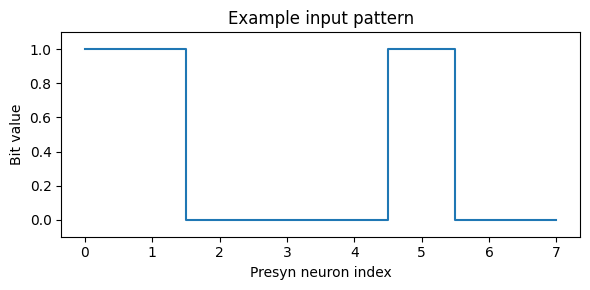

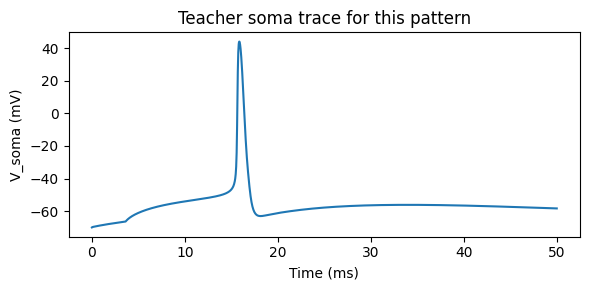

In [32]:
T = target_example.shape[0]
time_vec = np.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(num_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [33]:
N = patterns.shape[0]
idx = 500

assert 0 <= idx < N, f"idx {idx} out of range [0, {N-1}]"

pattern_example = patterns[idx]
target_example  = targets[idx]


AssertionError: idx 500 out of range [0, 199]

In [34]:
print("patterns shape:", patterns.shape)

for bad_idx in [200, 500, 10_000]:
    try:
        _ = patterns[bad_idx]
        print(f"Index {bad_idx} unexpectedly succeeded")
    except Exception as e:
        print(f"Index {bad_idx} raised: {repr(e)}")


patterns shape: (200, 8)
Index 200 unexpectedly succeeded
Index 500 unexpectedly succeeded
Index 10000 unexpectedly succeeded


OUT OF BOUNDS IS CLAMPED INTERNALLY? DEFAULTS TO LAST VALUE AKA IDX = 199

pattern_example shape: (8,)


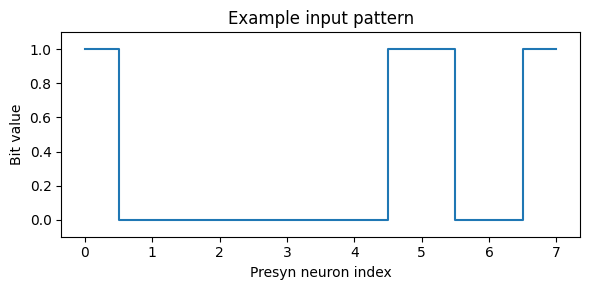

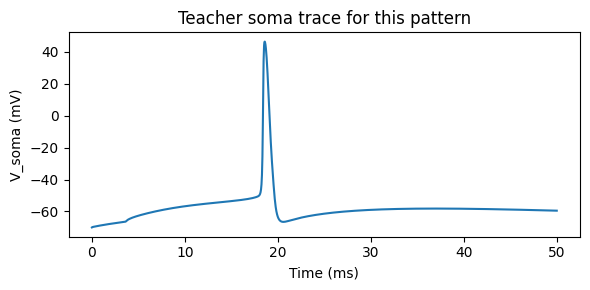

In [35]:
idx = 500
pattern_example = patterns[idx]
target_example  = targets[idx]   # shape (T,)
print("pattern_example shape:", pattern_example.shape)

# time axis from dt and T
T = target_example.shape[0]
time_vec = np.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(num_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [36]:
print("patterns[195]:", patterns[195])
print("patterns[196]:", patterns[196])
print("patterns[197]:", patterns[197])
print("patterns[198]:", patterns[198])

patterns[195]: [0. 0. 1. 0. 0. 1. 1. 0.]
patterns[196]: [0. 1. 1. 1. 1. 1. 1. 1.]
patterns[197]: [0. 1. 1. 1. 0. 0. 1. 0.]
patterns[198]: [1. 0. 1. 1. 1. 1. 1. 1.]


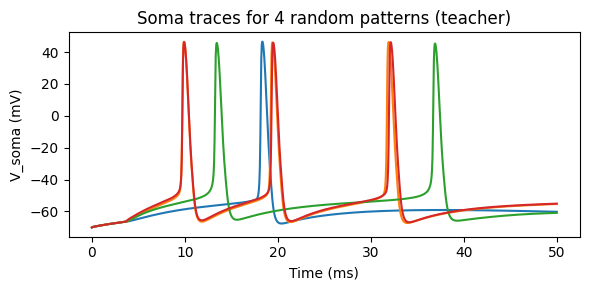

In [66]:
# run a small batch
traces = batched_simulate(params_true, patterns[195:199])  # (4, T)

T = traces.shape[1]
time_vec = np.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces.T)   # traces.T has shape (T, 4)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces for 4 random patterns (teacher)")
plt.tight_layout()
plt.show()


In [58]:
traces = batched_simulate(params_true, patterns[196:199])
max_diff = np.max(np.abs(traces[0] - traces[2]))
print("max |difference| between trace 0 and 1:", float(max_diff))


max |difference| between trace 0 and 1: 80.08121191649411


In [ ]:
traces = batched_simulate(params_true, patterns[196:197])  # indices 196,197,198
max_diff = np.max(np.abs(traces[0] - traces[4])) 
print("max |difference| between trace 0 and 1:", float(max_diff))         # 196 vs 197

pair = np.stack([patterns[196], patterns[198]], axis=0)   # shape (2, num_pre)
traces = batched_simulate(params_true, pair)              # shape (2, T)
max_diff = np.max(np.abs(traces[0] - traces[1]))
print("max |difference| between trace 0 and 1:", float(max_diff))

max |difference| between trace 0 and 1: 0.0
max |difference| between trace 0 and 1: 80.08121191649411


In [67]:
traces_batch = np.asarray(traces)   # make sure it's a NumPy array
n, T = traces_batch.shape

max_diffs = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        diff_ij = np.max(np.abs(traces_batch[i] - traces_batch[j]))
        max_diffs[i, j] = float(diff_ij)

print("pairwise max |difference|:")
print(max_diffs)

# Ignore self-comparisons
for i in range(n):
    max_diffs[i, i] = np.inf

# Find the closest pair
flat_idx = np.argmin(max_diffs)
i_min, j_min = divmod(flat_idx, n)

print(f"closest pair in this batch: {i_min} and {j_min}")
print(f"pattern indices in original array: {195 + i_min} and {195 + j_min}")
print(f"min max-diff: {max_diffs[i_min, j_min]:.6g}")


pairwise max |difference|:
[[  0.         105.91399573 107.86416749 105.73298921]
 [105.91399573   0.         107.97618582  80.08121192]
 [107.86416749 107.97618582   0.         107.67284344]
 [105.73298921  80.08121192 107.67284344   0.        ]]
closest pair in this batch: 1 and 3
pattern indices in original array: 196 and 198
min max-diff: 80.0812


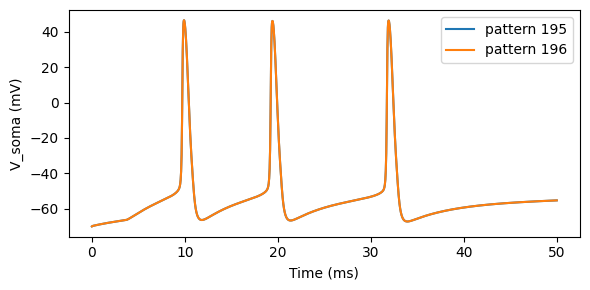

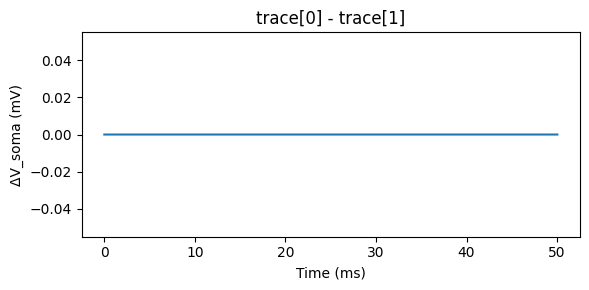

In [43]:
T = traces.shape[1]
time_vec = np.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0], label="pattern 195")
ax.plot(time_vec, traces[1], label="pattern 196")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0] - traces[1])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ΔV_soma (mV)")
ax.set_title("trace[0] - trace[1]")
plt.tight_layout()
plt.show()


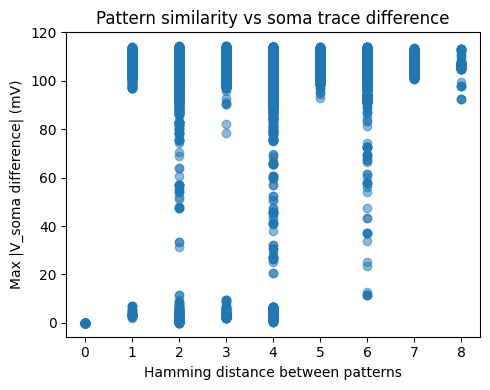

In [70]:
n_samples, num_pre = patterns.shape
_, T = targets.shape

# how many random pairs to sample
n_pairs = 100

rng = np.random.default_rng(0)

# sample random pairs (i, j), making sure i != j
idx_i = rng.integers(0, n_samples, size=n_pairs)
idx_j = rng.integers(0, n_samples, size=n_pairs)
mask = idx_i != idx_j
idx_i = idx_i[mask]
idx_j = idx_j[mask]

hamming_dists = []
max_diffs = []

for i in range(n_samples):
    for j in range(i+1, n_samples):
        h = int(np.sum(np.abs(patterns[i] - patterns[j])))
        d = float(np.max(np.abs(targets[i] - targets[j])))
        hamming_dists.append(h)
        max_diffs.append(d)

hamming_dists = np.array(hamming_dists)
max_diffs = np.array(max_diffs)

# scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(hamming_dists, max_diffs, alpha=0.5)
plt.xlabel("Hamming distance between patterns")
plt.ylabel("Max |V_soma difference| (mV)")
plt.title("Pattern similarity vs soma trace difference")
plt.tight_layout()
plt.show()


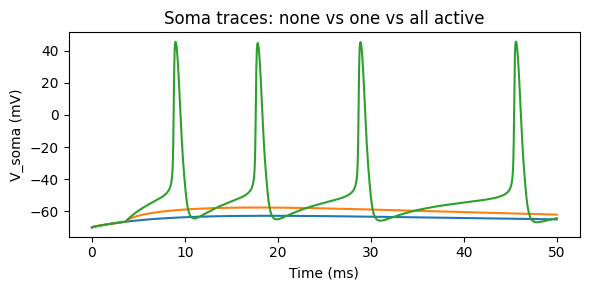

In [44]:
p_none = np.array([0, 0, 0, 0, 0.], dtype=np.float64)
p_one  = np.array([1, 0, 0, 0, 0.], dtype=np.float64)
p_all  = np.array([1, 1, 1, 1, 1.], dtype=np.float64)

ext_patterns = np.stack([p_none, p_one, p_all], axis=0)
ext_traces   = batched_simulate(params_true, ext_patterns)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, ext_traces.T)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces: none vs one vs all active")
plt.tight_layout()
plt.show()


SANITY DONE

TRAIN

In [45]:
key_learn = jax.random.PRNGKey(1)
noise_scale = 0.5

def add_noise_to_opt_params(opt_params, key, scale):
    leaves, treedef = jax.tree_util.tree_flatten(opt_params)
    subkeys = jax.random.split(key, len(leaves))
    noisy_leaves = [
        p + scale * jax.random.normal(k, p.shape)
        for p, k in zip(leaves, subkeys)
    ]
    return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)


In [46]:
print("opt_params_true:", opt_params_true)
print("opt_params_learn:", opt_params_learn)

opt_params_true: [{'IonotropicSynapse_gS': Array([-4.70048037, -4.70048037, -4.70048037, -4.70048037, -4.70048037,
       -4.70048037, -4.70048037, -4.70048037], dtype=float64)}]
opt_params_learn: [{'IonotropicSynapse_gS': Array([-4.15437057, -4.53451949, -5.15140135, -5.38955926, -4.48521748,
       -3.89707026, -4.6802116 , -5.09414458], dtype=float64)}]


In [47]:
def loss_fn(opt_params, patterns_batch, targets_batch):
    params = transform.forward(opt_params)
    preds = batched_simulate(params, patterns_batch)   # (B, T)
    return jnp.mean((preds - targets_batch) ** 2)

grad_fn = jit(value_and_grad(loss_fn, argnums=0))


In [48]:
import optax

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_params_learn)

num_steps = 500
print_every = 25

for step in range(num_steps + 1):
    train_loss, grads = grad_fn(opt_params_learn, patterns_train, targets_train)
    updates, opt_state = optimizer.update(grads, opt_state, opt_params_learn)
    opt_params_learn = optax.apply_updates(opt_params_learn, updates)

    if step % print_every == 0:
        val_loss = loss_fn(opt_params_learn, patterns_val, targets_val)
        print(f"step {step:4d} | train_loss={float(train_loss):.4e} "
              f"| val_loss={float(val_loss):.4e}")


step    0 | train_loss=4.8288e+02 | val_loss=4.9035e+02
step   25 | train_loss=2.8744e+02 | val_loss=3.4876e+02
step   50 | train_loss=2.7066e+02 | val_loss=3.2805e+02
step   75 | train_loss=2.5465e+02 | val_loss=3.1801e+02
step  100 | train_loss=2.4439e+02 | val_loss=3.0655e+02
step  125 | train_loss=2.4147e+02 | val_loss=3.1759e+02
step  150 | train_loss=2.5870e+02 | val_loss=3.0553e+02
step  175 | train_loss=2.5493e+02 | val_loss=3.0427e+02
step  200 | train_loss=2.3892e+02 | val_loss=2.9773e+02
step  225 | train_loss=2.3502e+02 | val_loss=2.8932e+02
step  250 | train_loss=2.3146e+02 | val_loss=2.8665e+02
step  275 | train_loss=2.3219e+02 | val_loss=2.7248e+02
step  300 | train_loss=2.1742e+02 | val_loss=2.6532e+02
step  325 | train_loss=1.9813e+02 | val_loss=2.4452e+02
step  350 | train_loss=1.7583e+02 | val_loss=2.1934e+02
step  375 | train_loss=1.5018e+02 | val_loss=1.8371e+02
step  400 | train_loss=1.0961e+02 | val_loss=1.0868e+02
step  425 | train_loss=3.0653e+01 | val_loss=3.1

In [49]:
train_loss_true = loss_fn(opt_params_true, patterns_train, targets_train)
val_loss_true   = loss_fn(opt_params_true, patterns_val, targets_val)
print("teacher train/val:", float(train_loss_true), float(val_loss_true))


teacher train/val: 0.0 0.0


In [50]:
params_learn_phys = transform.forward(opt_params_learn)
gS_true  = params_true[0]["IonotropicSynapse_gS"]
gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]

print("gS_true:",  gS_true)
print("gS_learn:", gS_learn)
print("max |diff|:", float(jnp.max(jnp.abs(gS_true - gS_learn))))


gS_true: [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
gS_learn: [1.00102863e-04 1.00156035e-04 1.00254079e-04 9.99974274e-05
 1.00213170e-04 1.00224306e-04 9.99929110e-05 1.00047234e-04]
max |diff|: 2.540786609881926e-07


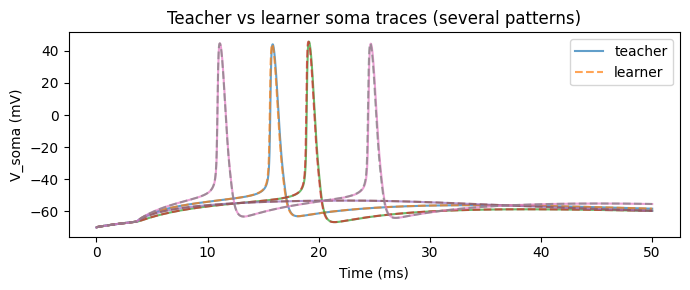

In [78]:
idxs = np.array([0, 1, 2, 3])  # any 4 indices < patterns_val.shape[0]

patterns_ex = patterns_train[idxs]       # (4, n_pre)
targets_ex  = targets_train[idxs]        # (4, T)


params_learn = transform.forward(opt_params_learn)


preds_ex = batched_simulate(params_learn, patterns_ex)   # (4, T)

T_ex = preds_ex.shape[1]
time_vec = np.arange(T_ex) * dt

plt.figure(figsize=(7, 3))
for i in range(len(idxs)):
    plt.plot(time_vec, targets_ex[i],       alpha=0.7, label="teacher" if i == 0 else None)
    plt.plot(time_vec, preds_ex[i], "--",   alpha=0.7, label="learner" if i == 0 else None)

plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs learner soma traces (several patterns)")
plt.legend()
plt.tight_layout()
plt.show()


GRADIENTS!

In [72]:
params_learn_phys = transform.forward(opt_params_learn)

In [ ]:
def single_loss_phys(params_phys, pattern, target_trace):
    pred = simulate(params_phys, pattern)   # uses params_phys directly now
    return jnp.mean((pred - target_trace) ** 2)


In [77]:
idx = 0 
pattern_ex = patterns_train[idx]
target_ex  = targets_train[idx]    

loss_val, grads_phys = value_and_grad(single_loss_phys)(
    params_learn_phys, pattern_ex, target_ex
)

print("single-example loss:", float(loss_val))

# gradient wrt synaptic conductances
gS_grad = grads_phys[0]["IonotropicSynapse_gS"]   # ndarray
print("gS_grad shape:", gS_grad.shape)
print("gS_grad (first few):", gS_grad[:10])

gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]
print("gS_learn shape:", gS_learn.shape)
print("gS_learn (first few):", gS_learn[:10])


single-example loss: 1.432999655402491
gS_grad shape: (8,)
gS_grad (first few): [6554360.79483729 6052840.7901116  1128384.18267996  974451.31210427
  838029.14486869 3159025.6013185   673784.66340544  648706.54036915]
gS_learn shape: (8,)
gS_learn (first few): [1.00102863e-04 1.00156035e-04 1.00254079e-04 9.99974274e-05
 1.00213170e-04 1.00224306e-04 9.99929110e-05 1.00047234e-04]


In [80]:
single_grad_phys = jax.grad(single_loss_phys, argnums=0)

grads_phys_train = vmap(
    single_grad_phys,
    in_axes=(None, 0, 0),    # params shared, patterns/targets batched
)(params_learn_phys, patterns_train, targets_train)

gS_grad_train = grads_phys_train[0]["IonotropicSynapse_gS"]   # shape (N_val, 8)
print("gS_grad_val shape:", gS_grad_train.shape)  # (N_val, 8)
print("first pattern grad:", gS_grad_train[0])

gS_grad_val shape: (160, 8)
first pattern grad: [6554360.79483565 6052840.79011006 1128384.18267968  974451.31210403
  838029.14486848 3159025.60131771  673784.66340527  648706.54036899]


In [82]:
print("gS_grad_train (first 5 rows):\n", np.array(gS_grad_train[:5]))


gS_grad_train (first 5 rows):
 [[6.55436079e+06 6.05284079e+06 1.12838418e+06 9.74451312e+05
  8.38029145e+05 3.15902560e+06 6.73784663e+05 6.48706540e+05]
 [1.73305263e+06 8.01731622e+06 1.59262213e+06 6.96970090e+06
  1.38808291e+06 1.30899423e+06 1.24604104e+06 5.51856445e+06]
 [9.61759596e+03 1.81068215e+03 7.90800926e+03 1.46670479e+03
  1.33164315e+03 1.22649830e+03 1.15712277e+03 1.12565525e+03]
 [7.30303041e+06 6.71841573e+06 1.21866055e+06 4.61611463e+06
  3.70426478e+06 7.02682567e+05 2.60133934e+06 5.81340468e+05]
 [2.19062926e+06 9.99138016e+06 9.13037510e+06 7.97438905e+06
  6.79864861e+06 1.30601967e+06 5.16434776e+06 1.12122230e+06]]


In [83]:
for n in range(5):
    print(f"pattern {n} bits:", patterns_train[n])
    print(f"gS_grad_train[{n}]:", gS_grad_train[n])
    print()


pattern 0 bits: [1. 1. 0. 0. 0. 1. 0. 0.]
gS_grad_train[0]: [6554360.79483565 6052840.79011006 1128384.18267968  974451.31210403
  838029.14486848 3159025.60131771  673784.66340527  648706.54036899]

pattern 1 bits: [0. 1. 0. 1. 0. 0. 0. 1.]
gS_grad_train[1]: [1733052.62674522 8017316.22328673 1592622.13432215 6969700.90289941
 1388082.90951104 1308994.22767393 1246041.04383028 5518564.45141014]

pattern 2 bits: [1. 0. 1. 0. 0. 0. 0. 0.]
gS_grad_train[2]: [9617.59595809 1810.68214786 7908.00925837 1466.70479079 1331.64315181
 1226.49830422 1157.12276789 1125.65525428]

pattern 3 bits: [1. 1. 0. 1. 1. 0. 1. 0.]
gS_grad_train[3]: [7303030.41253219 6718415.72731838 1218660.55271914 4616114.62506049
 3704264.78160487  702682.5674535  2601339.33899084  581340.46760612]

pattern 4 bits: [0. 1. 1. 1. 1. 0. 1. 0.]
gS_grad_train[4]: [2190629.26059132 9991380.16263103 9130375.10232141 7974389.05362631
 6798648.60628027 1306019.66588439 5164347.75508143 1121222.30450813]



In [84]:
row_norms = jnp.linalg.norm(gS_grad_train, axis=1)
print("first 10 row norms:", row_norms[:10])


first 10 row norms: [9.66311931e+06 1.24113423e+07 1.28976029e+04 1.19409076e+07
 1.80951955e+07 8.18414089e+07 2.40528977e+07 2.62429369e+07
 1.61679742e+07 1.04379318e+03]


DEFINE BIOPHYSICAL CORRELATES TO LOOK AT

In [85]:
params_learn_phys = transform.forward(opt_params_learn)

V_post_train_list = []
for patt in patterns_train:
    patt = jnp.asarray(patt)
    # simulate_all returns (num_recordings, T) = (n_post_comp, T)
    tr = simulate_all(params_learn_phys, patt)
    V_post_train_list.append(tr)

V_post_train = jnp.stack(V_post_train_list, axis=0)
# shape: (N_train, n_post_comp, T)
print("V_post_train shape:", V_post_train.shape)


V_post_train shape: (160, 15, 2002)


In [86]:
# student soma traces from these runs
soma_student_train = V_post_train[:, 0, :]           # (N_train, T)

# teacher soma traces are targets
soma_teacher_train = targets_train                   # (N_train, T)

# error trace
E_train = soma_student_train - soma_teacher_train    # (N_train, T)

# global error magnitude (RMS over time)
err_rms_train = jnp.sqrt(jnp.mean(E_train**2, axis=1))  # (N_train,)
print("err_rms_train shape:", err_rms_train.shape)


err_rms_train shape: (160,)


In [87]:
# select only compartments under synapses
# shape: (N_train, num_pre, T)
V_dend_syn_train = V_post_train[:, post_comp_indices, :]
print("V_dend_syn_train shape:", V_dend_syn_train.shape)


V_dend_syn_train shape: (160, 8, 2002)


In [100]:
def window_indices(t0, t1, dt):
    idx0 = int(np.round(t0 / dt))
    idx1 = int(np.round(t1 / dt))
    return idx0, idx1

t0_local = i_delay
t1_local = i_delay + 5.0
idx0, idx1 = window_indices(t0_local, t1_local, dt)
print("local window indices:", idx0, idx1)


local window indices: 120 320


In [89]:
# local mean dendritic voltage at synapse i for pattern n
local_mean_train = jnp.mean(V_dend_syn_train[:, :, idx0:idx1], axis=-1)
# shape: (N_train, num_pre)
print("local_mean_train shape:", local_mean_train.shape)


local_mean_train shape: (160, 8)


In [90]:
# broadcast global error over synapses
err_rms_mat = err_rms_train[:, None]         # (N_train, 1)

phi_local_err = local_mean_train * err_rms_mat  # (N_train, num_pre)
print("phi_local_err shape:", phi_local_err.shape)


phi_local_err shape: (160, 8)


In [91]:
# flatten
G_flat   = gS_grad_train.reshape(-1)
Phi_flat = phi_local_err.reshape(-1)

# z-score
G_z   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Phi_z = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

# Pearson correlation
corr = jnp.mean(G_z * Phi_z)
print("Pearson corr( Phi_local_err, AD gradient ) =", float(corr))


Pearson corr( Phi_local_err, AD gradient ) = -0.7389954113102155


In [92]:
local_flat = local_mean_train.reshape(-1)
local_z    = (local_flat - jnp.mean(local_flat)) / jnp.std(local_flat)
corr_local = jnp.mean(local_z * G_z)
print("Pearson corr( local_mean, AD gradient )    =", float(corr_local))


Pearson corr( local_mean, AD gradient )    = 0.21590272505196975


In [93]:
G_flat   = gS_grad_train.reshape(-1)
U_flat   = -G_flat                      # backprop update direction
Phi_flat = phi_local_err.reshape(-1)

# z-score
Gz   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Uz   = (U_flat   - jnp.mean(U_flat))   / jnp.std(U_flat)
Phiz = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

corr_update = jnp.mean(Phiz * Uz)
print("corr( Phi_local_err, BP update ) =", float(corr_update))


corr( Phi_local_err, BP update ) = 0.7389954113102155


In [94]:
def cosine(a, b, eps=1e-12):
    num = jnp.dot(a, b)
    den = jnp.linalg.norm(a) * jnp.linalg.norm(b) + eps
    return num / den

cosines = []
for n in range(gS_grad_train.shape[0]):
    u_n   = -gS_grad_train[n]
    phi_n = phi_local_err[n]
    cosines.append(cosine(u_n, phi_n))

cosines = jnp.stack(cosines)
print("mean cosine:", float(jnp.mean(cosines)))
print("std cosine:", float(jnp.std(cosines)))
print("min/max cosine:", float(jnp.min(cosines)), float(jnp.max(cosines)))


mean cosine: 0.7997354929162741
std cosine: 0.054724212343831624
min/max cosine: 0.6125408417813837 0.9179527711064943


Purely local dendritic depolarization alone has only weak positive correlation with the true gradient.

When you multiply local dendritic depolarization by a global somatic error magnitude, you get a per-synapse signal whose direction is strongly aligned with the true backprop update across patterns (mean cosine ≈ 0.8, range ~0.61–0.92).

In [99]:
def window_indices(t0, t1, dt):
    idx0 = int(np.round(t0 / dt))
    idx1 = int(np.round(t1 / dt))
    return idx0, idx1

t0_local = i_delay
t1_local = i_delay + 7.0
idx0, idx1 = window_indices(t0_local, t1_local, dt)
print("local window indices:", idx0, idx1)

# local mean dendritic voltage at synapse i for pattern n
local_mean_train = jnp.mean(V_dend_syn_train[:, :, idx0:idx1], axis=-1)
# shape: (N_train, num_pre)
print("local_mean_train shape:", local_mean_train.shape)

# broadcast global error over synapses
err_rms_mat = err_rms_train[:, None]         # (N_train, 1)

phi_local_err = local_mean_train * err_rms_mat  # (N_train, num_pre)
print("phi_local_err shape:", phi_local_err.shape)

# flatten
G_flat   = gS_grad_train.reshape(-1)
Phi_flat = phi_local_err.reshape(-1)

# z-score
G_z   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Phi_z = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

# Pearson correlation
corr = jnp.mean(G_z * Phi_z)
print("Pearson corr( Phi_local_err, AD gradient ) =", float(corr))

G_flat   = gS_grad_train.reshape(-1)
U_flat   = -G_flat                      # backprop update direction
Phi_flat = phi_local_err.reshape(-1)

# z-score
Gz   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Uz   = (U_flat   - jnp.mean(U_flat))   / jnp.std(U_flat)
Phiz = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

corr_update = jnp.mean(Phiz * Uz)
print("corr( Phi_local_err, BP update ) =", float(corr_update))

def cosine(a, b, eps=1e-12):
    num = jnp.dot(a, b)
    den = jnp.linalg.norm(a) * jnp.linalg.norm(b) + eps
    return num / den

cosines = []
for n in range(gS_grad_train.shape[0]):
    u_n   = -gS_grad_train[n]
    phi_n = phi_local_err[n]
    cosines.append(cosine(u_n, phi_n))

cosines = jnp.stack(cosines)
print("mean cosine:", float(jnp.mean(cosines)))
print("std cosine:", float(jnp.std(cosines)))
print("min/max cosine:", float(jnp.min(cosines)), float(jnp.max(cosines)))


local_flat = local_mean_train.reshape(-1)
local_z    = (local_flat - jnp.mean(local_flat)) / jnp.std(local_flat)
corr_local = jnp.mean(local_z * G_z)
print("Pearson corr( local_mean, AD gradient )    =", float(corr_local))


local window indices: 120 400
local_mean_train shape: (160, 8)
phi_local_err shape: (160, 8)
Pearson corr( Phi_local_err, AD gradient ) = -0.738396646081398
corr( Phi_local_err, BP update ) = 0.738396646081398
mean cosine: 0.7970544161422612
std cosine: 0.05385716562908725
min/max cosine: 0.6113640755231874 0.91764468405812
Pearson corr( local_mean, AD gradient )    = 0.11788842799331223


In [108]:
V_soma = soma_student_train  # (N_train, T)

def detect_spikes(v_trace, thresh=0.0):
    above = v_trace > thresh
    # rising edges: (v[t-1] <= thresh) & (v[t] > thresh)
    edges = jnp.logical_and(~above[:-1], above[1:])
    return jnp.where(edges)[0] + 1        # spike indices

spike_times = [detect_spikes(v) for v in V_soma]  # list of arrays of spike indices

print("Example spike indices for pattern 0:", spike_times[0][:10])
print("num spikes per pattern (first 10):", [len(st) for st in spike_times[:10]])

Example spike indices for pattern 0: [624]
num spikes per pattern (first 10): [1, 1, 0, 2, 2, 3, 2, 2, 1, 0]


In [109]:
delta_idx = int(2.0 / dt)  # 2 ms after spike

N_train, N_syn, T = V_dend_syn_train.shape
bap_local = jnp.zeros((N_train, N_syn))

for n in range(N_train):
    spikes_n = spike_times[n]  # 1D array of spike indices

    if spikes_n.size == 0:
        continue

    for i in range(N_syn):
        # gather local dend trace at synapse i
        v_i = V_dend_syn_train[n, i]  # (T,)

        # for each spike, max in [t_k, t_k + delta]
        vals = []
        for t_k in spikes_n:
            t_end = jnp.minimum(t_k + delta_idx, T)
            vals.append(jnp.max(v_i[t_k:t_end]))
        # sum over spikes
        bap_local = bap_local.at[n, i].set(jnp.sum(jnp.stack(vals)))
print("bap_local shape:", bap_local.shape)  # (N_train, 8)
print("bap_local[0]:", bap_local[0])

bap_local shape: (160, 8)
bap_local[0]: [44.06582958 43.10508805 42.50977529 42.30930949 42.26704657 42.06765476
 43.85922243 46.64308639]


In [110]:
err_rms_mat = err_rms_train[:, None]
phi_bap_err = bap_local * err_rms_mat    # (N_train, N_syn)
print("phi_bap_err shape:", phi_bap_err.shape)


phi_bap_err shape: (160, 8)


In [111]:
# flatten
G_flat   = gS_grad_train.reshape(-1)
U_flat   = -G_flat
Phi_flat = phi_bap_err.reshape(-1)

# z-score
Gz   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Uz   = (U_flat   - jnp.mean(U_flat))   / jnp.std(U_flat)
Phiz = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

corr_update_bap = jnp.mean(Phiz * Uz)
print("corr( Phi_bap_err, BP update ) =", float(corr_update_bap))

# pattern-wise cosines
cosines_bap = []
for n in range(gS_grad_train.shape[0]):
    u_n   = -gS_grad_train[n]
    phi_n = phi_bap_err[n]
    cosines_bap.append(cosine(u_n, phi_n))
cosines_bap = jnp.stack(cosines_bap)
print("BAP mean cosine:", float(jnp.mean(cosines_bap)))
print("BAP std cosine:", float(jnp.std(cosines_bap)))
print("BAP min/max cosine:", float(jnp.min(cosines_bap)), float(jnp.max(cosines_bap)))


corr( Phi_bap_err, BP update ) = -0.5952641410548828
BAP mean cosine: -0.5168498030799621
BAP std cosine: 0.3676229452070711
BAP min/max cosine: -0.917708671580722 0.2634232963696551


In [112]:
# signed mean error over the whole trace
err_signed_train = jnp.mean(E_train, axis=1)   # (N_train,)
print("err_signed_train shape:", err_signed_train.shape)
print("first 5 signed errors:", err_signed_train[:5])


err_signed_train shape: (160,)
first 5 signed errors: [0.01580199 0.00845917 0.03815427 0.01528016 0.01440739]


In [113]:
err_signed_mat = err_signed_train[:, None]     # (N_train, 1)
phi_bap_signed = bap_local * err_signed_mat    # (N_train, 8)
print("phi_bap_signed shape:", phi_bap_signed.shape)


phi_bap_signed shape: (160, 8)


In [114]:
# flatten
G_flat   = gS_grad_train.reshape(-1)
U_flat   = -G_flat                      # backprop update direction
Phi_flat = phi_bap_signed.reshape(-1)

# z-score
Gz   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Uz   = (U_flat   - jnp.mean(U_flat))   / jnp.std(U_flat)
Phiz = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

corr_update_bap_signed = jnp.mean(Phiz * Uz)
print("corr( Phi_bap_signed, BP update ) =", float(corr_update_bap_signed))


corr( Phi_bap_signed, BP update ) = 0.6637008371312845


In [115]:
def cosine(a, b, eps=1e-12):
    num = jnp.dot(a, b)
    den = jnp.linalg.norm(a) * jnp.linalg.norm(b) + eps
    return num / den

cosines_bap_signed = []
for n in range(gS_grad_train.shape[0]):
    u_n   = -gS_grad_train[n]        # (8,)
    phi_n = phi_bap_signed[n]        # (8,)
    cosines_bap_signed.append(cosine(u_n, phi_n))

cosines_bap_signed = jnp.stack(cosines_bap_signed)
print("BAP-signed mean cosine:", float(jnp.mean(cosines_bap_signed)))
print("BAP-signed std cosine:", float(jnp.std(cosines_bap_signed)))
print("BAP-signed min/max cosine:",
      float(jnp.min(cosines_bap_signed)), float(jnp.max(cosines_bap_signed)))


BAP-signed mean cosine: -0.0921575960830684
BAP-signed std cosine: 0.6275247614801401
BAP-signed min/max cosine: -0.8827974036339814 0.9177086715807219


In [116]:

V_dend_syn_np = np.array(V_dend_syn_train)  # (N_train, 8, T)
N_train, N_syn, T = V_dend_syn_np.shape

# define pre- and post-spike windows
pre_ms  = 3.0   # EPSP window before spike
post_ms = 2.0   # BAP window after spike

pre_idx  = int(np.round(pre_ms  / dt))
post_idx = int(np.round(post_ms / dt))
print("pre_idx, post_idx:", pre_idx, post_idx)

coinc_local = np.zeros((N_train, N_syn))

for n in range(N_train):
    spikes_n = spike_times[n]
    if len(spikes_n) == 0:
        continue

    for i in range(N_syn):
        v_i = V_dend_syn_np[n, i]  # (T,)
        val = 0.0
        for t_k in spikes_n:
            # pre-spike window [t_k - pre_idx, t_k)
            t_pre0 = max(t_k - pre_idx, 0)
            t_pre1 = t_k
            if t_pre0 < t_pre1:
                epsp = float(v_i[t_pre0:t_pre1].mean())
            else:
                epsp = 0.0

            # post-spike window [t_k, t_k + post_idx]
            t_post0 = t_k
            t_post1 = min(t_k + post_idx, T)
            if t_post0 < t_post1:
                bap = float(v_i[t_post0:t_post1].max())
            else:
                bap = 0.0

            val += epsp * bap

        coinc_local[n, i] = val

coinc_local = jnp.asarray(coinc_local)
print("coinc_local shape:", coinc_local.shape)
print("coinc_local[0]:", coinc_local[0])


pre_idx, post_idx: 120 80
coinc_local shape: (160, 8)
coinc_local[0]: [-2103.24010022 -2145.25419121 -2222.35422368 -2278.77324129
 -2311.97223425 -2310.75192915 -2444.63130731 -2613.94856438]


In [117]:
# global RMS error (already computed earlier)
# err_rms_train: (N_train,)

err_rms_mat = err_rms_train[:, None]          # (N_train, 1)
phi_coinc_err = coinc_local * err_rms_mat     # (N_train, 8)

print("phi_coinc_err shape:", phi_coinc_err.shape)
print("phi_coinc_err[0]:", phi_coinc_err[0])


phi_coinc_err shape: (160, 8)
phi_coinc_err[0]: [-2517.74589401 -2568.04010677 -2660.33498559 -2727.87304266
 -2767.61488108 -2766.15407869 -2926.418356   -3129.10459649]


In [118]:
# flatten
G_flat   = gS_grad_train.reshape(-1)
U_flat   = -G_flat                      # backprop update direction
Phi_flat = phi_coinc_err.reshape(-1)

# z-score
Gz   = (G_flat   - jnp.mean(G_flat))   / jnp.std(G_flat)
Uz   = (U_flat   - jnp.mean(U_flat))   / jnp.std(U_flat)
Phiz = (Phi_flat - jnp.mean(Phi_flat)) / jnp.std(Phi_flat)

corr_update_coinc = jnp.mean(Phiz * Uz)
print("corr( Phi_coinc_err, BP update ) =", float(corr_update_coinc))


corr( Phi_coinc_err, BP update ) = 0.5699420807759129


In [119]:
def cosine(a, b, eps=1e-12):
    num = jnp.dot(a, b)
    den = jnp.linalg.norm(a) * jnp.linalg.norm(b) + eps
    return num / den

cosines_coinc = []
for n in range(gS_grad_train.shape[0]):
    u_n   = -gS_grad_train[n]    # (8,)
    phi_n = phi_coinc_err[n]     # (8,)
    cosines_coinc.append(cosine(u_n, phi_n))

cosines_coinc = jnp.stack(cosines_coinc)
print("coinc mean cosine:", float(jnp.mean(cosines_coinc)))
print("coinc std cosine:", float(jnp.std(cosines_coinc)))
print("coinc min/max cosine:",
      float(jnp.min(cosines_coinc)), float(jnp.max(cosines_coinc)))


coinc mean cosine: 0.5162500790618213
coinc std cosine: 0.33429729209867765
coinc min/max cosine: -0.07413424682416367 0.912014368005569


In [120]:
coinc_flat = coinc_local.reshape(-1)
coinc_z    = (coinc_flat - jnp.mean(coinc_flat)) / jnp.std(coinc_flat)
corr_local_coinc = jnp.mean(coinc_z * Gz)
print("Pearson corr( coinc_local, AD gradient ) =", float(corr_local_coinc))


Pearson corr( coinc_local, AD gradient ) = -0.13560420553766164
